In [1]:
import os
from entsoe import EntsoePandasClient
from dotenv import load_dotenv
import pandas as pd
from datetime import datetime
from zoneinfo import ZoneInfo
import matplotlib.pyplot as plt

In [2]:
if os.getenv("ENTSOE_API_KEY") is None or load_dotenv() is False:
    raise ValueError("ENTSOE_API_KEY should either be exported or present in a .env file")

In [3]:
client = EntsoePandasClient(api_key=os.getenv("ENTSOE_API_KEY"))

In [4]:
# Get the current time in Helsinki timezone
helsinki_tz = ZoneInfo("Europe/Helsinki")
now = datetime.now(helsinki_tz)

# Set start to the beginning of the current day
start = pd.Timestamp(now.replace(hour=0, minute=0, second=0, microsecond=0))

# Set end to 24 hours after start
end = start + pd.Timedelta(days=1)

# Query the day-ahead prices
prices = client.query_day_ahead_prices(country_code="FI", start=start, end=end)


## Visual bullshit-check

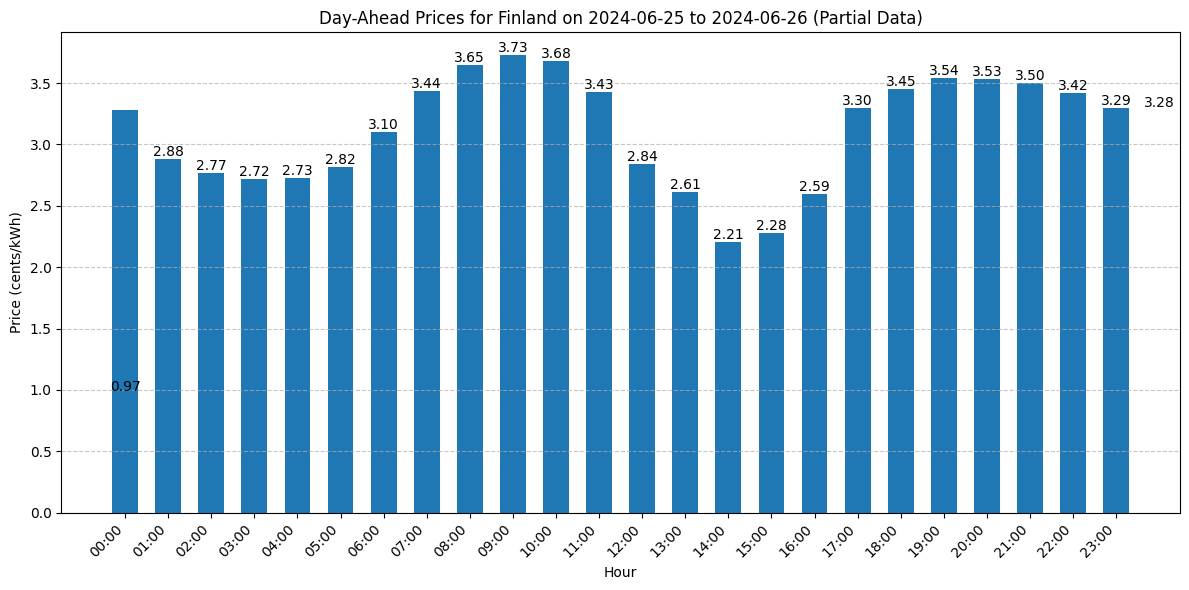

Number of hours with price data: 25
Time range: From 2024-06-25 00:00:00+03:00 to 2024-06-26 00:00:00+03:00


In [5]:
df = pd.DataFrame(prices, columns=['Price'])

# Convert prices from EUR/MWh to cents/kWh
df['Price'] = df['Price'] / 10  # Divide by 10 to convert EUR/MWh to cents/kWh

df['Hour'] = df.index.strftime('%H:%M')

plt.figure(figsize=(12, 6))
plt.bar(df['Hour'], df['Price'], width=0.6)

full_day = len(df) == 24
title_date = start.date() if full_day else f"{start.date()} to {end.date()}"
title_suffix = "" if full_day else " (Partial Data)"

plt.title(f'Day-Ahead Prices for Finland on {title_date}{title_suffix}')
plt.xlabel('Hour')
plt.ylabel('Price (cents/kWh)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, price in enumerate(df['Price']):
    plt.text(i, price, f'{price:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"Number of hours with price data: {len(df)}")
print(f"Time range: From {df.index.min()} to {df.index.max()}")

## These are electricity prices, but as docile ratepayers we need to add distribution and tax

add values based on your provider. Ours is [Caruna](https://caruna.fi/en/products-and-services/home-and-real-estate/electricity-distribution-prices)

Electricity tax as of 1 January 2021 

    Tax bracket 1: 2.79372 cents/kWh (incl. VAT 24% and security of supply charge) 
    Tax bracket 2: 0.07812 cents/kWh (incl. VAT 24% and security of supply charge)

Furthermore, lets add a hypothetical fixed price contract for the electricity part, to see who is the <s>biggest looser</s> generous ratepayer

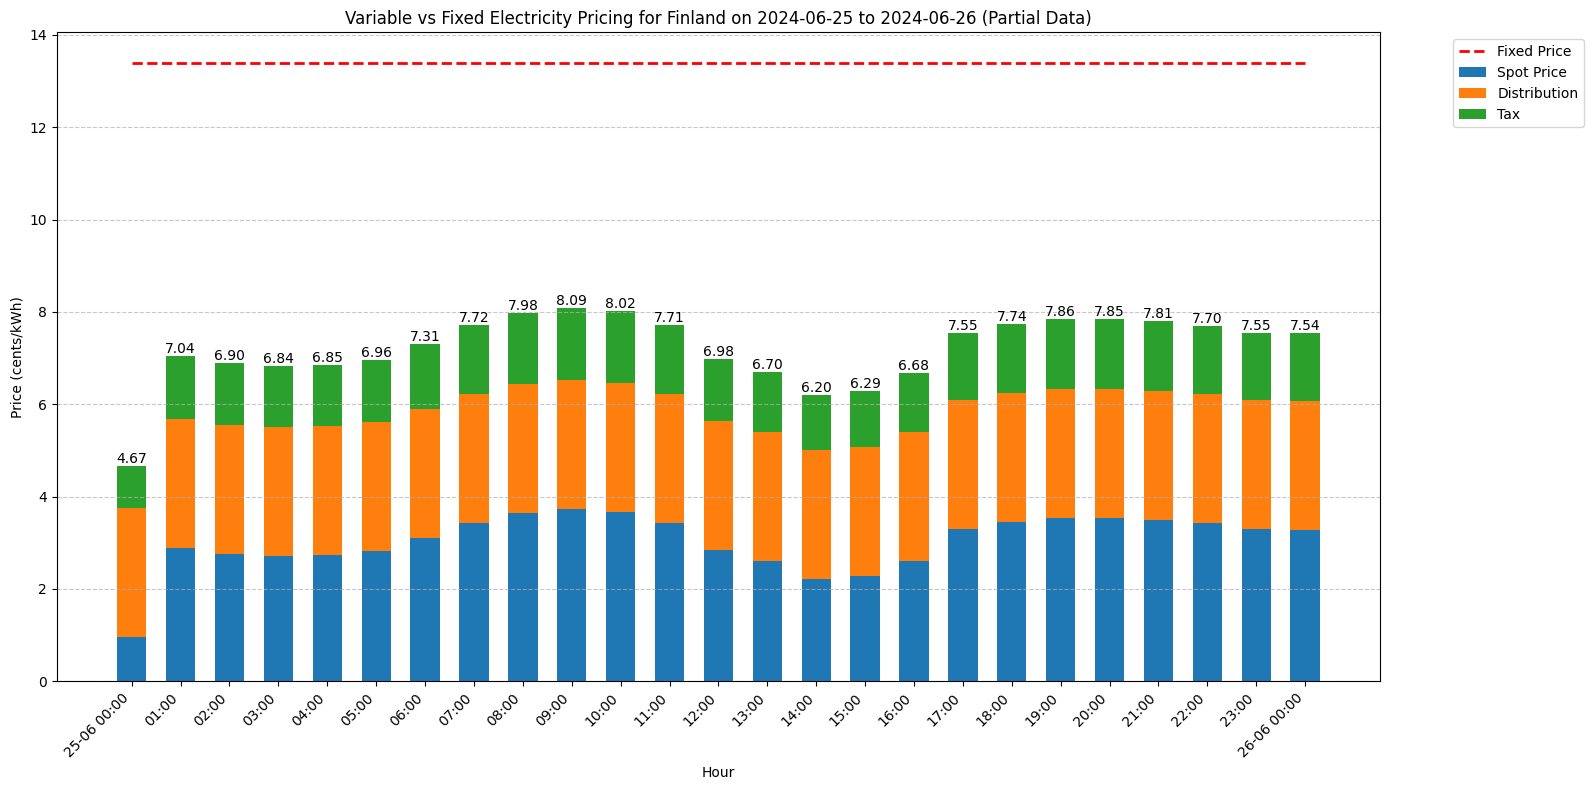

Number of hours with price data: 25
Time range: From 2024-06-25 00:00:00+03:00 to 2024-06-26 00:00:00+03:00

Average prices (cents/kWh):
Variable Total: 7.22
Fixed Total: 13.38

Price difference:
Average Variable - Fixed = -6.16 cents/kWh
Variable pricing is cheaper


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

distribution_cost = 2.79372
tax_percentage = 1.24
fixed_price = 8.0  # Hypothetical fixed price (cents/kWh, before tax). Adjust me!

def calculate_total_price(spot_price):
    pre_tax_total = spot_price + distribution_cost
    return pre_tax_total * tax_percentage

df = pd.DataFrame(prices, columns=['Spot Price'])

# Convert prices from EUR/MWh to cents/kWh
df['Spot Price'] = df['Spot Price'] / 10
df['Distribution'] = distribution_cost
df['Pre-tax Total'] = df['Spot Price'] + df['Distribution']
df['Tax'] = df['Pre-tax Total'] * (tax_percentage - 1)
df['Variable Total'] = df['Pre-tax Total'] * tax_percentage

# Calculate total price for fixed pricing
fixed_total = calculate_total_price(fixed_price)
df['Fixed Total'] = fixed_total

# Create custom x-axis labels to avoid the 00:00 overwriting on the plot later
df['Hour'] = df.index.strftime('%H:%M')
df.loc[df['Hour'] == '00:00', 'Hour'] = df.index[df['Hour'] == '00:00'].strftime('%d-%m %H:%M')

fig, ax1 = plt.subplots(figsize=(16, 8))  # Increased figure width to accommodate legend
ax1.bar(range(len(df)), df['Spot Price'], label='Spot Price', width=0.6)
ax1.bar(range(len(df)), df['Distribution'], bottom=df['Spot Price'], label='Distribution', width=0.6)
ax1.bar(range(len(df)), df['Tax'], bottom=df['Pre-tax Total'], label='Tax', width=0.6)
ax1.plot(range(len(df)), df['Fixed Total'], label='Fixed Price', linestyle='--', color='red', linewidth=2)

full_day = len(df) == 24
title_date = df.index[0].date() if full_day else f"{df.index[0].date()} to {df.index[-1].date()}"
title_suffix = "" if full_day else " (Partial Data)"
ax1.set_title(f'Variable vs Fixed Electricity Pricing for Finland on {title_date}{title_suffix}')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Price (cents/kWh)')
ax1.set_xticks(range(len(df)))
ax1.set_xticklabels(df['Hour'], rotation=45, ha='right')
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Move legend outside the plot to avoid masking data
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

for i, total_price in enumerate(df['Variable Total']):
    ax1.text(i, total_price, f'{total_price:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"Number of hours with price data: {len(df)}")
print(f"Time range: From {df.index.min()} to {df.index.max()}")
print(f"\nAverage prices (cents/kWh):")
print(f"Variable Total: {df['Variable Total'].mean():.2f}")
print(f"Fixed Total: {fixed_total:.2f}")
print(f"\nPrice difference:")
difference = df['Variable Total'].mean() - fixed_total
print(f"Average Variable - Fixed = {difference:.2f} cents/kWh")
print(f"{'Variable pricing is cheaper' if difference < 0 else 'Fixed pricing is cheaper'}")


In [10]:
df

,Spot Price,Distribution,Pre-tax Total,Tax,Variable Total,Fixed Total,Hour
2024-06-25 00:00:00+03:00,0.970,2.79372,3.76372,0.903293,4.667013,13.384213,00:00
2024-06-25 01:00:00+03:00,2.883,2.79372,5.67672,1.362413,7.039133,13.384213,01:00
2024-06-25 02:00:00+03:00,2.767,2.79372,5.56072,1.334573,6.895293,13.384213,02:00
2024-06-25 03:00:00+03:00,2.719,2.79372,5.51272,1.323053,6.835773,13.384213,03:00
2024-06-25 04:00:00+03:00,2.730,2.79372,5.52372,1.325693,6.849413,13.384213,04:00
2024-06-25 05:00:00+03:00,2.817,2.79372,5.61072,1.346573,6.957293,13.384213,05:00
2024-06-25 06:00:00+03:00,3.102,2.79372,5.89572,1.414973,7.310693,13.384213,06:00
2024-06-25 07:00:00+03:00,3.436,2.79372,6.22972,1.495133,7.724853,13.384213,07:00
2024-06-25 08:00:00+03:00,3.645,2.79372,6.43872,1.545293,7.984013,13.384213,08:00
2024-06-25 09:00:00+03:00,3.727,2.79372,6.52072,1.564973,8.085693,13.384213,09:00
